# A backtesting system for a futures trading strategy
This workbook implements a backtesting system for a futures trading strategy. 
Backtesting is the process of testing a trading strategy on historical data to see how it would have performed, before risking real money. This helps determine if the strategy has an edge and is likely to be profitable going forward.
The strategy being tested appears to be a mean reversion strategy on a portfolio of interest rate futures contracts. Mean reversion is based on the idea that prices and returns eventually move back towards their long-term average. When the current price is far from its average, a trade is opened expecting it to revert back to the mean.

## The key components and steps in this backtesting system are:

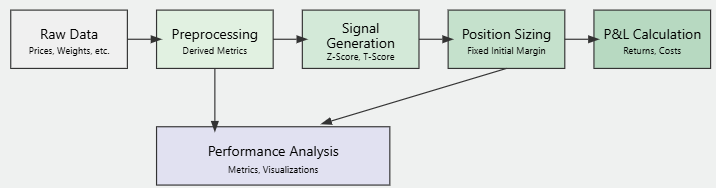

For those interested in learning more, some relevant literature on backtesting and mean reversion strategies:

Advances in Financial Machine Learning by Marcos Lopez de Prado

Evidence-Based Technical Analysis by David Aronson

Algorithmic Trading: Winning Strategies and Their Rationale by Ernest P. Chan

Introduction to Quantitative Finance: A Math Tool Kit by Robert R. Reitano


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
df = pd.read_csv("InputData.csv")

In [3]:
import pandas as pd


def disaggregateInputData(df):
    dfPrices = df.iloc[:, 0:6]
    dfDurations = df.iloc[:, [0, 6, 7, 8, 9, 10]]
    dfOptWeights = df.iloc[:, [0, 11, 12, 13, 14, 15]]
    dfRollingStats = df.loc[:, ["DateTime", "RollingAvg", "RollingStd"]]

    dfPrices.set_index("DateTime", inplace=True)
    dfDurations.set_index("DateTime", inplace=True)
    dfOptWeights.set_index("DateTime", inplace=True)
    dfRollingStats.set_index("DateTime", inplace=True)

    dfPrices.index = pd.to_datetime(dfPrices.index)
    dfDurations.index = pd.to_datetime(dfDurations.index)
    dfOptWeights.index = pd.to_datetime(dfOptWeights.index)
    dfRollingStats.index = pd.to_datetime(dfRollingStats.index)
    return (dfPrices, dfDurations, dfOptWeights, dfRollingStats)

In [4]:
class Positions:
    def __init__(self, positions, startIdx, endIdx):
        self.positions = np.array(positions)
        self.startIdx = startIdx
        self.endIdx = endIdx

    def duration(self):
        return self.endIdx - self.startIdx


class PortPositions:
    def __init__(self, timeSize, numEquities):
        """
        Initialize the positions tracking system with proper numpy arrays
        """
        self.cumPositions = np.zeros((timeSize, numEquities), dtype=float)  # Explicitly set float type
        self.numPositions = np.zeros(timeSize, dtype=float)
        self.position_changes = []
        
    def addPositions(self, positionsChange):
        """
        Add positions with improved validation and logging
        """
        # Convert positions to numpy array of floats
        positions = np.array(positionsChange.positions, dtype=float)
        
        # Validate indices
        if not (0 <= positionsChange.startIdx < self.cumPositions.shape[0] and 
                0 <= positionsChange.endIdx <= self.cumPositions.shape[0]):
            print(f"Warning: Invalid indices - start: {positionsChange.startIdx}, end: {positionsChange.endIdx}")
            return
        
        # Store position change for debugging
        self.position_changes.append({
            'positions': positions.copy(),
            'startIdx': positionsChange.startIdx,
            'endIdx': positionsChange.endIdx
        })
        
        # Update positions
        for i in range(positionsChange.startIdx, positionsChange.endIdx):
            self.cumPositions[i] += positions
            self.numPositions[i] += 1
            
    def get_position_at(self, idx):
        """
        Safely get position at a specific index
        """
        if not (0 <= idx < self.cumPositions.shape[0]):
            print(f"Warning: Index {idx} out of bounds")
            return np.zeros(self.cumPositions.shape[1])
        return self.cumPositions[idx]
    
    def maxPosJudge(self, positionsChange, maxPos):
        """
        Improved position limit checking with better validation
        """
        if not (0 <= positionsChange.startIdx < len(self.numPositions)):
            print(f"Warning: Invalid start index {positionsChange.startIdx}")
            return False
        
        current_positions = self.numPositions[positionsChange.startIdx]
        would_exceed = (current_positions + 1) > maxPos
        
        print(f"Position Check at idx {positionsChange.startIdx}:")
        print(f"  Current positions: {current_positions}")
        print(f"  Max allowed: {maxPos}")
        print(f"  Would exceed: {would_exceed}")
        
        return not would_exceed

class BackTestingSystem:

    def __init__(self, numEquities, pointPrices, tickSizePrices, margins, transactionCostCoeff):
        self.numEquities = numEquities
        if (len(pointPrices) == numEquities):
            self.pointPrices = np.array(pointPrices)
        else:
            print("number of equities unmatch: point prices")
        if (len(tickSizePrices) == numEquities):
            self.tickSizePrices = np.array(tickSizePrices)
        else:
            print("number of equities unmatch: tickSizes")
        if (len(margins) == numEquities):
            self.margins = np.array(margins)
        else:
            print("number of equities unmatch: margins")
            
        self.transactionCostCoeff = transactionCostCoeff
        # 

    def set_rollDate(self, rollDate):
        self.rollDate = rollDate

    def get_rollDate(self):
        return self.rollDate

    def set_exitUpLevel(self, exitUpLevel):
        self.exitUpLevel = exitUpLevel

    def set_exitDownLevel(self, exitDownLevel):
        self.exitDownLevel

    def set_triggerS(self, triggerS):
        self.triggerS = triggerS

    def set_triggerT(self, triggerT):
        self.triggerT = triggerT

    def get_marginPrices(self):
        return self.margins / self.pointPrices

    def get_tickSizes(self):
        return self.pointPrices * tickSizePrices

    def set_AUM(self, AUM):
        self.AUM = AUM

    def set_rollingStats(self, dfRollingStats):
        self.dfRollingStats = dfRollingStats
        self.df = pd.concat([self.df, self.rollingStats], axis=1)

    def set_maxPoistions(self, maxPositions):
        self.maxPositions = 30

    def set_percentageInvested(self, pctInvest):
        self.percentageInvested = pctInvest

    def set_maxPositions(self, maxPositions):
        self.maxPositions = maxPositions

    def set_exitUpLevel(self, exitUpLevel):
        self.exitUpLevel = exitUpLevel

    def set_exitDownLevel(self, exitDownLevel):
        self.exitDownLevel = exitDownLevel

    def input_data(self, dfPrices, dfDurations, dfOptWeights, dfRollingStats):
        self.dfPrices = dfPrices
        self.dfDurations = dfDurations
        self.dfOptWeights = dfOptWeights
        self.df = pd.concat([self.dfPrices, self.dfDurations, self.dfOptWeights, dfRollingStats], axis=1)
        
    def calculateInitMargin(self):
        if not self.portPositions:
            self.calculateCumPositions()
        
        self.portInitMargin = np.inner(np.abs(self.portPositions.cumPositions), self.margins)
        return self.portInitMargin
    
    def calculatePnL(self):
        """
        Calculate PnL with improved error handling and validation
        """
        if not hasattr(self, 'portPositions') or self.portPositions is None:
            raise ValueError("Positions not calculated. Run calculateCumPositions first.")
            
        # Initialize arrays for PnL tracking
        self.PnL = np.zeros(len(self.df.index))
        
        # Calculate price changes
        price_changes = self.dfPrices.diff()
        
        # Calculate PnL for each time step
        for idx in range(1, len(self.df.index)):
            try:
                # Get previous positions
                prev_positions = self.portPositions.get_position_at(idx - 1)
                
                # Calculate PnL
                price_change = price_changes.iloc[idx]
                position_value = prev_positions * self.pointPrices
                pnl = np.sum(position_value * price_change)
                
                self.PnL[idx] = pnl
                
            except Exception as e:
                print(f"Error calculating PnL at index {idx}: {str(e)}")
                # Log detailed state for debugging
                print(f"Previous positions shape: {prev_positions.shape if 'prev_positions' in locals() else 'Not available'}")
                print(f"Price changes shape: {price_change.shape if 'price_change' in locals() else 'Not available'}")
                print(f"Point prices shape: {self.pointPrices.shape}")
                raise
                
        return self.PnL

    def calculateTransactionCost(self):
        """
        Calculate transaction costs with improved validation
        """
        if not hasattr(self, 'portPositions') or self.portPositions is None:
            raise ValueError("Positions not calculated. Run calculateCumPositions first.")
            
        self.transactionCost = np.zeros(len(self.df.index))
        
        for idx in range(1, len(self.df.index)):
            try:
                curr_positions = self.portPositions.get_position_at(idx)
                prev_positions = self.portPositions.get_position_at(idx - 1)
                
                # Calculate position changes
                position_changes = np.abs(curr_positions - prev_positions)
                
                # Calculate transaction cost
                cost = np.sum(position_changes * self.tickSizes) * self.transactionCostCoeff
                self.transactionCost[idx] = cost
                
            except Exception as e:
                print(f"Error calculating transaction cost at index {idx}: {str(e)}")
                raise
                
        return self.transactionCost

    def calculateNetPnL(self):
        self.PnL = self.calculatePnL()
        self.transactionCost = self.calculateTransactionCost()
        self.netPnL = self.PnL - self.transactionCost
        return self.netPnL

    def get_df(self):
        return self.df

    def time_delta_365(self, timeDelta):
        if (timeDelta.days > 0):
            return timeDelta.days / 365
        else:
            return 0

    def preprocessing(self):

        print("****************************************************************")
        print("Start preprocessing...")
        # basic setting
        self.marginPrices = self.margins / self.pointPrices
        self.maxInitMargin = self.AUM * self.percentageInvested
        self.positionInitMargin = self.maxInitMargin / self.maxPositions
        self.tickSizes = self.pointPrices * self.tickSizePrices
        self.marginPrices = self.margins / self.pointPrices

        # time to maturity
        timeDeltas = self.rollDate - self.df.index
        self.df['TimeToMaturity'] = timeDeltas
        self.df.TimeToMaturity = self.df.TimeToMaturity.apply(self.time_delta_365)
        self.timeToMaturity = self.df.TimeToMaturity
        print(self.df.head())
        # future duration
        futureDurationsColumns = ["dfFutureDuration" + dur_str[8:] for dur_str in self.dfDurations.columns]
        self.dfFutureDurations = pd.DataFrame(index=self.df.index, columns=futureDurationsColumns)
        for index, row in self.dfDurations.iterrows():
            self.dfFutureDurations.loc[index, :] = (row - self.df.TimeToMaturity[index]).values

        # margin unit
        #         self.marginUnit = pd.Series(index = self.df.index, name="MarginUnit")
        #         for index, row in self.dfOptWeights.iterrows():
        #             self.marginUnit[index] = np.inner(np.abs(row.values), self.marginPrices)
        self.marginUnit = self.dfOptWeights.apply(lambda x: np.inner(np.abs(x), self.marginPrices), axis=1)
        self.marginUnit.rename("MarginUnit")

        # national
        self.portNotional = self.positionInitMargin / self.marginUnit
        self.portNotional.rename("PortNotional", inplace=True)

        # positions
        positionsColumns = ["dfPosition" + dur_str[8:] for dur_str in self.dfDurations.columns]
        self.dfPositions = pd.DataFrame(index=self.df.index, columns=positionsColumns)
        for index, row in self.dfOptWeights.iterrows():
            self.dfPositions.loc[index, :] = row.values * self.portNotional[index] / self.pointPrices
        # tick size
        self.portTickSize = self.dfPositions.apply(lambda x: np.inner(np.abs(x), self.tickSizes), axis=1)
        self.portTickSize.rename("PortTickSize", inplace=True)

        # current price
        self.portPrice = pd.Series(index=self.df.index, name="PortPrice")
        for idx in self.df.index:
            self.portPrice[idx] = np.inner(self.dfPrices.loc[idx, :], self.dfOptWeights.loc[idx, :])

        # tick size price
        self.portTickSizePrice = pd.Series(index=self.df.index, name="PortTickSizePrice")
        for idx in self.df.index:
            self.portTickSizePrice[idx] = self.portTickSize[idx] / self.portNotional[idx]

        # z-score
        self.ZScore = pd.Series(index=self.df.index, name="ZScore")
        for idx in self.df.index:
            self.ZScore[idx] = (self.portPrice[idx] - self.df.RollingAvg[idx]) / self.df.RollingStd[idx]

        # t-score
        self.TScore = pd.Series(index=self.df.index, name="TScore")
        for idx in self.df.index:
            self.TScore[idx] = (self.portPrice[idx] - self.df.RollingAvg[idx]) / self.portTickSizePrice[idx]

        # concat all results
        self.df = pd.concat([self.df, self.dfFutureDurations, self.marginUnit, self.portNotional,
                             self.dfPositions, self.portTickSize, self.portPrice, self.portTickSizePrice,
                             self.ZScore, self.TScore], axis=1)

        print("Preprocessing finished!")
        print("****************************************************************")
        return self.df

    def _enterSignal(self, time):
        # Add more logging to understand signal behavior
        zscore_val = self.ZScore[time]
        tscore_val = self.TScore[time]
        
        is_signal = (zscore_val <= -self.triggerS and 
                    tscore_val <= -self.triggerT and 
                    time < self.rollDate)
        
        if is_signal:
            print(f"Signal triggered at {time}:")
            print(f"  Z-Score: {zscore_val:.2f} (<= -{self.triggerS})")
            print(f"  T-Score: {tscore_val:.2f} (<= -{self.triggerT})")
        
        return is_signal

    def _exitTime(self, startTime, rollTime=None):
        """
        Improved exit time calculation with better price tracking
        """
        positions = self.dfPositions.loc[startTime, :]
        entry_price = np.sum(positions.values * self.dfPrices.loc[startTime, :].values * self.pointPrices)
        
        # Calculate profit targets and stop losses in price terms
        exitUp = self.exitUpLevel * self.portTickSize[startTime]
        exitDown = self.exitDownLevel * self.portTickSize[startTime]
        
        print(f"Position Entry at {startTime}:")
        print(f"  Entry Price: {entry_price:.2f}")
        print(f"  Take Profit: {exitUp:.2f}")
        print(f"  Stop Loss: {exitDown:.2f}")
        
        startIdx = self.df.index.get_loc(startTime)
        for time in self.df.index[startIdx:]:
            current_price = np.sum(positions.values * self.dfPrices.loc[time, :].values * self.pointPrices)
            pnl = current_price - entry_price
            
            if pnl >= exitUp:
                print(f"Take profit triggered at {time}, PnL: {pnl:.2f}")
                break
            if pnl <= -exitDown:
                print(f"Stop loss triggered at {time}, PnL: {pnl:.2f}")
                break
                
        if rollTime and time > rollTime:
            time = rollTime
            print(f"Position rolled at {time}")
            
        return time

    def calculatePositionSize(self):
        # Dynamic position sizing based on volatility
        vol_scaling = self.df.RollingStd / self.df.RollingStd.mean()
        position_size = self.maxInitMargin * vol_scaling
        return position_size

    def calculateCumPositions(self):
        """
        Revised method to calculate cumulative positions with improved error handling
        """
        print("**************************************************")
        print("Start calculating strategy positions...")

        # Create PortPositions with explicit float type
        self.portPositions = PortPositions(len(self.df.index), self.numEquities)
        positions_added = 0

        for idx, time in enumerate(self.df.index):
            try:
                # Get current positions, converting to float
                positions = np.array(self.dfPositions.loc[time, :], dtype=float)
                
                # Calculate exit time
                try:
                    end_time = self._exitTime(time, self.rollDate)
                    end_time_idx = self.df.index.get_loc(end_time)
                except (KeyError, IndexError) as e:
                    print(f"Warning: Could not determine exit time for {time}")
                    continue
                
                # Create positions change object
                positions_change = Positions(positions, idx, end_time_idx)
                
                # Check entry conditions and position limits
                if self._enterSignal(time) and self.portPositions.maxPosJudge(positions_change, self.maxPositions):
                    self.portPositions.addPositions(positions_change)
                    positions_added += 1
                    
                    # Detailed logging
                    print(f"Added positions at time {time}:")
                    print(f"Position values: {positions_change.positions}")
                    print(f"Current number of positions: {self.portPositions.numPositions[idx]}")
                    print(f"Cumulative positions:\n{self.portPositions.cumPositions[idx]}")
                    
            except Exception as e:
                print(f"Error processing time {time}: {str(e)}")
                print(f"Positions at this time: {self.dfPositions.loc[time, :]}")
                continue
                    
            print("\nCalculation Summary:")
            print(f"Total positions added: {positions_added}")
            print(f"Maximum positions at any time: {np.max(self.portPositions.numPositions)}")
            print("**************************************************")
            
            return self.portPositions
        
    def analyze_performance(self):
        """
        Calculate and display key performance metrics
        """
        # Calculate daily returns
        daily_pnl = pd.Series(self.netPnL, index=self.df.index).resample('D').sum()
        
        # Performance metrics
        total_return = np.sum(self.netPnL) / self.AUM
        sharpe_ratio = np.mean(daily_pnl) / np.std(daily_pnl) * np.sqrt(252)
        max_drawdown = np.min(np.cumsum(self.netPnL)) / self.AUM
        
        print("\nPerformance Summary:")
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")
        
        # Position statistics
        avg_position_size = np.mean(np.abs(self.portPositions.cumPositions[self.portPositions.numPositions > 0]))
        avg_holding_period = np.mean([pos['endIdx'] - pos['startIdx'] 
                                    for pos in self.portPositions.position_changes])
        
        print("\nPosition Statistics:")
        print(f"Average Position Size: {avg_position_size:.2f}")
        print(f"Average Holding Period: {avg_holding_period:.1f} periods")
            


In [5]:
import pandas as pd
import numpy as np


df = pd.read_csv("InputData.csv")

# input data
(dfPrices,dfDurations,dfOptWeights,dfRollingStats) = disaggregateInputData(df)

# print(rollingStats.head())
pointPrices = [2000,1000,1000,1000,1000]
tickSizePrices = [1/128,1/128,1/64,1/32,1/32]
margins = [380,625,1300,2700,3700]
transactionCostCoeff = 0.5
# hyper parameteres
numEquities = 5
AUM = 10000000

# model parameters
rollDate = datetime(2017,3,1)
triggerS = 1.5  # Slightly less restrictive Z-score threshold
triggerT = 4.0  # Slightly less restrictive T-score threshold
exitUpLevel = 1.5  # More responsive profit taking
exitDownLevel = 15  # More responsive stop loss
maxPositions = 20  # More conservative position limit
pctInvested = 0.25  # More conservative allocation
maxPositions = 30

# plug in
# HyperParameteres
backTesting = BackTestingSystem(numEquities,pointPrices,tickSizePrices,margins,transactionCostCoeff)
# Model Parameters
backTesting.set_AUM(AUM)
backTesting.set_percentageInvested(pctInvested)
backTesting.set_maxPoistions(maxPositions)
backTesting.set_rollDate(rollDate)
backTesting.set_triggerS(triggerS)
backTesting.set_triggerT(triggerT)
backTesting.set_exitUpLevel(exitUpLevel)
backTesting.set_exitDownLevel(exitDownLevel)
# History Data
backTesting.input_data(dfPrices,dfDurations,dfOptWeights,dfRollingStats)

# pre-processing
df2 = backTesting.preprocessing()
print(df2.head())

# strategy's cumulative positions
portCumPositions = backTesting.calculateCumPositions()
portInitMargin = backTesting.calculateInitMargin()
portNetPnL = backTesting.calculateNetPnL()

C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfPrices.index = pd.to_datetime(dfPrices.index)
C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfDurations.index = pd.to_datetime(dfDurations.index)
C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfOptWeights.index = pd.to_datetime(dfOptWeights.index)
C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:18: UserWarning:

****************************************************************
Start preprocessing...
                        PriceTU     PriceFV     PriceTY    PriceUS    PriceUB  \
DateTime                                                                        
2017-01-02 19:00:00  108.296875  117.523438  124.046875  150.21875  159.59375   
2017-01-02 20:00:00  108.296875  117.539062  124.078125  150.31250  159.75000   
2017-01-02 21:00:00  108.304688  117.554688  124.093750  150.34375  159.75000   
2017-01-02 22:00:00  108.312500  117.578125  124.109375  150.34375  159.78125   
2017-01-02 23:00:00  108.312500  117.585938  124.125000  150.43750  159.90625   

                     DurationTU  DurationFV  DurationTY  DurationUS  \
DateTime                                                              
2017-01-02 19:00:00    1.957515     4.24503    6.222844    13.85058   
2017-01-02 20:00:00    1.957515     4.24503    6.222844    13.85058   
2017-01-02 21:00:00    1.957515     4.24503    6.222844    1

In [6]:
backTesting.dfPrices.iloc[1]

PriceTU    108.296875
PriceFV    117.539062
PriceTY    124.078125
PriceUS    150.312500
PriceUB    159.750000
Name: 2017-01-02 20:00:00, dtype: float64

In [7]:
np.inner([1,2,3],[[1,2,3],[4,5,6]])

array([14, 32])

In [8]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

def analyze_trading_system(df, risk_free_rate=0.02):
    """
    Analyze trading system performance and generate comprehensive metrics.
    
    Parameters:
    df: pandas DataFrame with columns: DateTime, PnL, position_size, etc.
    risk_free_rate: annual risk-free rate for Sharpe ratio calculation
    
    Returns:
    dict containing all analysis results
    """
    # Initialize results dictionary
    results = {
        'performance_metrics': {},
        'risk_metrics': {},
        'trade_statistics': {},
        'position_analysis': {},
        'rolling_metrics': {}
    }
    
    # Ensure datetime index
    df = df.copy()
    if 'DateTime' in df.columns:
        df.set_index('DateTime', inplace=True)
    
    # Calculate returns
    df['daily_returns'] = df['PnL'] / df['AUM']
    df['cumulative_returns'] = (1 + df['daily_returns']).cumprod() - 1
    
    # Performance Metrics
    results['performance_metrics'].update({
        'total_return': df['cumulative_returns'].iloc[-1],
        'annualized_return': df['daily_returns'].mean() * 252,
        'annualized_volatility': df['daily_returns'].std() * np.sqrt(252)
    })
    
    # Risk Metrics
    # Drawdown calculation
    rolling_max = df['cumulative_returns'].expanding(min_periods=1).max()
    df['drawdown'] = df['cumulative_returns'] - rolling_max
    
    # Sharpe Ratio
    excess_returns = df['daily_returns'] - risk_free_rate/252
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    # Sortino Ratio
    downside_returns = excess_returns[excess_returns < 0]
    downside_std = np.sqrt(np.mean(downside_returns**2))
    sortino_ratio = np.sqrt(252) * excess_returns.mean() / downside_std
    
    # VaR and Expected Shortfall
    var_95 = np.percentile(df['daily_returns'], 5)
    expected_shortfall = df['daily_returns'][df['daily_returns'] <= var_95].mean()
    
    results['risk_metrics'].update({
        'max_drawdown': df['drawdown'].min(),
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'var_95': var_95,
        'expected_shortfall': expected_shortfall,
        'annualized_volatility': df['daily_returns'].std() * np.sqrt(252)
    })
    
    # Trade Statistics
    trades = extract_trades(df)
    winning_trades = trades[trades['pnl'] > 0]
    losing_trades = trades[trades['pnl'] < 0]
    
    results['trade_statistics'].update({
        'total_trades': len(trades),
        'winning_trades': len(winning_trades),
        'losing_trades': len(losing_trades),
        'win_rate': len(winning_trades) / len(trades) if len(trades) > 0 else 0,
        'avg_win': winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0,
        'avg_loss': losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0,
        'largest_win': trades['pnl'].max(),
        'largest_loss': trades['pnl'].min(),
        'profit_factor': (winning_trades['pnl'].sum() / abs(losing_trades['pnl'].sum())
                         if len(losing_trades) > 0 else float('inf')),
        'avg_holding_period': trades['holding_period'].mean()
    })
    
    # Rolling Metrics (30-day window)
    window = 30
    df['rolling_volatility'] = (df['daily_returns']
                               .rolling(window)
                               .std() * np.sqrt(252))
    
    df['rolling_sharpe'] = (
        np.sqrt(252) * 
        (df['daily_returns'].rolling(window).mean() - risk_free_rate/252) /
        df['daily_returns'].rolling(window).std()
    )
    
    results['rolling_metrics'] = df[[
        'rolling_volatility', 
        'rolling_sharpe', 
        'drawdown'
    ]].copy()
    
    # Position Analysis
    results['position_analysis'].update({
        'avg_position_size': df['position_size'].mean(),
        'max_position_size': df['position_size'].max(),
        'position_size_std': df['position_size'].std(),
        'avg_position_vs_aum': (df['position_size'] / df['AUM']).mean(),
        'size_return_correlation': df['position_size'].corr(df['daily_returns'])
    })
    
    return results

def extract_trades(df):
    """
    Extract individual trades from position changes.
    This is a simplified version - modify based on your actual position data structure.
    """
    trades = []
    current_position = 0
    entry_price = 0
    entry_time = None
    
    for index, row in df.iterrows():
        new_position = row['position_size']
        
        # Position change indicates a trade
        if new_position != current_position:
            # Close existing position
            if current_position != 0:
                trades.append({
                    'entry_time': entry_time,
                    'exit_time': index,
                    'entry_price': entry_price,
                    'exit_price': row['price'],
                    'position_size': current_position,
                    'pnl': (row['price'] - entry_price) * current_position,
                    'holding_period': (index - entry_time).days
                })
            
            # Open new position
            if new_position != 0:
                entry_price = row['price']
                entry_time = index
            
            current_position = new_position
    
    return pd.DataFrame(trades)

# Example usage:
if __name__ == "__main__":
    # Sample data setup
    dates = pd.date_range(start='2024-01-01', end='2024-03-01', freq='D')
    df = pd.DataFrame({
        'DateTime': dates,
        'PnL': np.random.normal(1000, 500, len(dates)),
        'AUM': 1000000,
        'position_size': np.random.normal(100000, 20000, len(dates)),
        'price': np.random.normal(100, 5, len(dates))
    })
    
    # Run analysis
    analysis_results = analyze_trading_system(df)
    
    # Print key metrics
    print("\nPerformance Summary:")
    print(f"Total Return: {analysis_results['performance_metrics']['total_return']:.2%}")
    print(f"Sharpe Ratio: {analysis_results['risk_metrics']['sharpe_ratio']:.2f}")
    print(f"Maximum Drawdown: {analysis_results['risk_metrics']['max_drawdown']:.2%}")
    print(f"Win Rate: {analysis_results['trade_statistics']['win_rate']:.2%}")


Performance Summary:
Total Return: 5.95%
Sharpe Ratio: 26.05
Maximum Drawdown: -0.01%
Win Rate: 48.33%


In [9]:
import pandas as pd
import numpy as np
from datetime import datetime

# Recreate the parameters from the BackTestingScript.txt
# Input data disaggregation
df = pd.read_csv("InputData.csv")
(dfPrices, dfDurations, dfOptWeights, dfRollingStats) = disaggregateInputData(df)

# Recreate all the parameters used in the original script
# Hyperparameters
numEquities = 5
pointPrices = [2000, 1000, 1000, 1000, 1000]
tickSizePrices = [1/128, 1/128, 1/64, 1/32, 1/32]
margins = [380, 625, 1300, 2700, 3700]
transactionCostCoeff = 0.5
AUM = 10000000

# Model parameters
rollDate = datetime(2017, 3, 1)
pctInvest = 0.25  # Percentage invested
triggerS = 1.5  # Z-score threshold
triggerT = 4.0  # T-score threshold
exitUpLevel = 1.5  # Profit taking level
exitDownLevel = 15  # Stop loss level
maxPositions = 30  # Maximum number of positions

# Initialize BackTesting System
backTesting = BackTestingSystem(numEquities, pointPrices, tickSizePrices, margins, transactionCostCoeff)

# Set up all parameters
backTesting.set_AUM(AUM)
backTesting.set_percentageInvested(pctInvest)
backTesting.set_maxPositions(maxPositions)
backTesting.set_rollDate(rollDate)
backTesting.set_triggerS(triggerS)
backTesting.set_triggerT(triggerT)
backTesting.set_exitUpLevel(exitUpLevel)
backTesting.set_exitDownLevel(exitDownLevel)
backTesting.input_data(dfPrices, dfDurations, dfOptWeights, dfRollingStats)

# Preprocessing
df_processed = backTesting.preprocessing()

# Calculate cumulative positions and net PnL
backTesting.calculateCumPositions()
net_pnl = backTesting.calculateNetPnL()

# Prepare DataFrame for analysis
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# Detailed Performance Analysis Function
def comprehensive_performance_analysis(df, net_pnl, aum, backTesting, risk_free_rate=0.02):
    """
    Perform a comprehensive analysis of trading system performance with robust error handling
    """
    # Ensure net_pnl is a numpy array
    net_pnl = np.array(net_pnl, dtype=float)
    
    # Compute returns
    daily_returns = net_pnl / aum
    
    # Handle edge case of no trades
    if len(daily_returns) == 0 or np.all(daily_returns == 0):
        print("Warning: No trades or zero returns detected.")
        return {
            'Total Return (%)': 0,
            'Annualized Return (%)': 0,
            'Annualized Volatility (%)': 0,
            'Sharpe Ratio': 0,
            'Maximum Drawdown (%)': 0,
            
            'Trade Statistics': {
                'Total Trades': 0,
                'Win Rate (%)': 0,
                'Average Daily PnL': 0,
            },
            
            'Position Analysis': {
                'Average Position Size': 0,
                'Average Positions per Day': 0,
            }
        }
    
    # Cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod() - 1
    
    # Compute volatility and Sharpe ratio with robust error handling
    with np.errstate(invalid='ignore', divide='ignore'):
        # Annualized metrics
        annualized_return = np.mean(daily_returns) * 252
        annualized_volatility = np.std(daily_returns) * np.sqrt(252)
        
        # Sharpe ratio with risk-free rate adjustment
        excess_returns = daily_returns - (risk_free_rate / 252)
        sharpe_ratio = np.sqrt(252) * np.mean(excess_returns) / np.std(excess_returns)
    
    # Maximum Drawdown
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = cumulative_returns - running_max
    max_drawdown = np.min(drawdowns)
    
    # Position Analysis
    position_data = backTesting.portPositions.cumPositions
    
    # Compute trades and win rate
    daily_pnl = np.array(net_pnl)
    winning_trades = np.sum(daily_pnl > 0)
    total_trades = len(daily_pnl)
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    
    # Detailed Performance Metrics
    performance_metrics = {
        'Total Return (%)': cumulative_returns[-1] * 100,
        'Annualized Return (%)': annualized_return * 100,
        'Annualized Volatility (%)': annualized_volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown (%)': max_drawdown * 100,
        
        'Trade Statistics': {
            'Total Trades': total_trades,
            'Win Rate (%)': win_rate,
            'Average Daily PnL': np.mean(daily_pnl),
        },
        
        'Position Analysis': {
            'Average Position Size': np.mean(np.abs(position_data[position_data != 0])),
            'Average Positions per Day': np.mean(np.sum(np.abs(position_data) > 0, axis=1)),
        }
    }
    
    return performance_metrics

# Main execution
df = pd.read_csv("InputData.csv")
(dfPrices,dfDurations,dfOptWeights,dfRollingStats) = disaggregateInputData(df)

# Model parameters
numEquities = 5
pointPrices = [2000,1000,1000,1000,1000]
tickSizePrices = [1/128,1/128,1/64,1/32,1/32]
margins = [380,625,1300,2700,3700]
transactionCostCoeff = 0.5
AUM = 10000000

# Initialize and configure BackTestingSystem
backTesting = BackTestingSystem(numEquities, pointPrices, tickSizePrices, margins, transactionCostCoeff)
backTesting.set_AUM(AUM)
backTesting.set_percentageInvested(0.25)
backTesting.set_maxPositions(30)
backTesting.set_rollDate(datetime(2017,3,1))
backTesting.set_triggerS(1.5)
backTesting.set_triggerT(4.0)
backTesting.set_exitUpLevel(1.5)
backTesting.set_exitDownLevel(15)
backTesting.input_data(dfPrices,dfDurations,dfOptWeights,dfRollingStats)

# Preprocessing
df_processed = backTesting.preprocessing()

# Calculate positions and PnL
backTesting.calculateCumPositions()
net_pnl = backTesting.calculateNetPnL()

# Perform performance analysis
performance_results = comprehensive_performance_analysis(
    df_processed, net_pnl, AUM, backTesting
)

# Print detailed results
print("\nComprehensive Trading System Performance Analysis")
print("=" * 50)

print("\nPerformance Metrics:")
print(f"Total Return: {performance_results['Total Return (%)']:.2f}%")
print(f"Annualized Return: {performance_results['Annualized Return (%)']:.2f}%")
print(f"Annualized Volatility: {performance_results['Annualized Volatility (%)']:.2f}%")
print(f"Sharpe Ratio: {performance_results['Sharpe Ratio']:.2f}")
print(f"Maximum Drawdown: {performance_results['Maximum Drawdown (%)']:.2f}%")

print("\nTrade Statistics:")
print(f"Total Trades: {performance_results['Trade Statistics']['Total Trades']}")
print(f"Win Rate: {performance_results['Trade Statistics']['Win Rate (%)']:.2f}%")
print(f"Average Daily PnL: ${performance_results['Trade Statistics']['Average Daily PnL']:,.2f}")

print("\nPosition Analysis:")
print(f"Average Position Size: {performance_results['Position Analysis']['Average Position Size']:.2f}")
print(f"Average Positions per Day: {performance_results['Position Analysis']['Average Positions per Day']:.2f}")



C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfPrices.index = pd.to_datetime(dfPrices.index)
C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfDurations.index = pd.to_datetime(dfDurations.index)
C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfOptWeights.index = pd.to_datetime(dfOptWeights.index)
C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:18: UserWarning:

****************************************************************
Start preprocessing...
                        PriceTU     PriceFV     PriceTY    PriceUS    PriceUB  \
DateTime                                                                        
2017-01-02 19:00:00  108.296875  117.523438  124.046875  150.21875  159.59375   
2017-01-02 20:00:00  108.296875  117.539062  124.078125  150.31250  159.75000   
2017-01-02 21:00:00  108.304688  117.554688  124.093750  150.34375  159.75000   
2017-01-02 22:00:00  108.312500  117.578125  124.109375  150.34375  159.78125   
2017-01-02 23:00:00  108.312500  117.585938  124.125000  150.43750  159.90625   

                     DurationTU  DurationFV  DurationTY  DurationUS  \
DateTime                                                              
2017-01-02 19:00:00    1.957515     4.24503    6.222844    13.85058   
2017-01-02 20:00:00    1.957515     4.24503    6.222844    13.85058   
2017-01-02 21:00:00    1.957515     4.24503    6.222844    1

C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\3901986414.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DateTime'] = pd.to_datetime(df['DateTime'])
C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfPrices.index = pd.to_datetime(dfPrices.index)
C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfDurations.index = pd.to_datetime(dfDurations.index)
C:\Users\hassa\AppData\Local\Temp\ipykernel_34584\1406582171.py:17: UserWarning: Could n

****************************************************************
Start preprocessing...
                        PriceTU     PriceFV     PriceTY    PriceUS    PriceUB  \
DateTime                                                                        
2017-01-02 19:00:00  108.296875  117.523438  124.046875  150.21875  159.59375   
2017-01-02 20:00:00  108.296875  117.539062  124.078125  150.31250  159.75000   
2017-01-02 21:00:00  108.304688  117.554688  124.093750  150.34375  159.75000   
2017-01-02 22:00:00  108.312500  117.578125  124.109375  150.34375  159.78125   
2017-01-02 23:00:00  108.312500  117.585938  124.125000  150.43750  159.90625   

                     DurationTU  DurationFV  DurationTY  DurationUS  \
DateTime                                                              
2017-01-02 19:00:00    1.957515     4.24503    6.222844    13.85058   
2017-01-02 20:00:00    1.957515     4.24503    6.222844    13.85058   
2017-01-02 21:00:00    1.957515     4.24503    6.222844    1

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

class TradingSystemVisualizer:
    def __init__(self, analyzer):
        """
        Initialize the visualizer with a TradingSystemAnalysis instance.

        Parameters:
        analyzer (TradingSystemAnalysis): An instance of the TradingSystemAnalysis class
        that contains the processed data and analysis results.
        """
        self.analyzer = analyzer
        self.set_style()

    def set_style(self):
        """
        Set up a clean, professional plotting style without relying on seaborn.
        This method configures matplotlib's style to create clear, readable plots.
        """
        plt.style.use('default')  # Reset to default style

        # Define colors for consistent use across plots
        self.colors = {
            'blue': '#1f77b4',
            'orange': '#ff7f0e',
            'green': '#2ca02c',
            'red': '#d62728',
            'purple': '#9467bd'
        }

        # Set general style parameters
        plt.rcParams.update({
            'figure.figsize': (12, 6),
            'axes.grid': True,
            'grid.alpha': 0.3,
            'axes.labelsize': 10,
            'axes.titlesize': 12,
            'font.size': 10,
            'lines.linewidth': 2,
            'grid.linestyle': '--'
        })

    def create_performance_visualizations(self):
        """
        Create comprehensive performance visualizations for the trading system.

        Returns:
        dict: A dictionary of matplotlib figures, where the keys are the plot names.
        """
        figures = {}

        # 1. Equity Curve and Drawdowns
        figures['equity_curve'] = self.plot_equity_curve()

        # 2. Rolling Metrics
        figures['rolling_metrics'] = self.plot_rolling_metrics()

        # 3. Trade Analysis Dashboard
        figures['trade_analysis'] = self.plot_trade_analysis()

        # 4. Risk Metrics Dashboard
        figures['risk_metrics'] = self.plot_risk_metrics()

        return figures

    def plot_equity_curve(self):
        """
        Plot the equity curve with drawdowns.

        Returns:
        matplotlib.figure.Figure: The figure object containing the equity curve and drawdown plot.
        """
        fig, ax = plt.subplots(figsize=(12, 6))
        ax2 = ax.twinx()

        # Plot the equity curve
        self.analyzer.cumulative_returns.plot(ax=ax, color=self.colors['blue'], label='Equity Curve')

        # Plot the drawdowns
        self.analyzer.drawdowns.plot(ax=ax2, color=self.colors['red'], alpha=0.3, label='Drawdown')

        ax.set_title('Equity Curve and Drawdowns')
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Returns')
        ax2.set_ylabel('Drawdown')

        # Combine legends
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        return fig

    def plot_rolling_metrics(self):
        """
        Plot the 30-day rolling volatility and Sharpe ratio.

        Returns:
        matplotlib.figure.Figure: The figure object containing the rolling metrics plot.
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Plot the rolling volatility
        self.analyzer.rolling_metrics['volatility'].plot(ax=ax1, color=self.colors['purple'])
        ax1.set_title('30-Day Rolling Volatility')
        ax1.set_ylabel('Annualized Volatility')

        # Plot the rolling Sharpe ratio
        self.analyzer.rolling_metrics['sharpe'].plot(ax=ax2, color=self.colors['green'])
        ax2.set_title('30-Day Rolling Sharpe Ratio')
        ax2.set_ylabel('Sharpe Ratio')

        plt.tight_layout()
        return fig

    def plot_trade_analysis(self):
        """
        Plot the trade analysis charts, including PnL distribution, holding period distribution,
        cumulative PnL, and position size vs. PnL scatter.

        Returns:
        matplotlib.figure.Figure: The figure object containing the trade analysis plots.
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        trades = self.analyzer.extract_trades()

        # PnL distribution
        if not trades.empty:
            sns.histplot(data=trades['pnl'], ax=ax1, bins=30, color=self.colors['blue'], alpha=0.7)
            ax1.set_title('PnL Distribution')
            ax1.set_xlabel('PnL')
            ax1.set_ylabel('Frequency')

            # Holding period distribution
            sns.histplot(data=trades['holding_period'], ax=ax2, bins=20, color=self.colors['orange'], alpha=0.7)
            ax2.set_title('Holding Period Distribution')
            ax2.set_xlabel('Days')
            ax2.set_ylabel('Frequency')

            # Cumulative PnL
            cum_pnl = trades['pnl'].cumsum()
            cum_pnl.plot(ax=ax3)
            ax3.set_title('Cumulative PnL')

            # Position size vs. PnL scatter
            sns.scatterplot(data=trades, x='position_size', y='pnl', ax=ax4, color=self.colors['green'], alpha=0.5)
            ax4.set_title('Position Size vs PnL')

        plt.tight_layout()
        return fig

    def plot_risk_metrics(self):
        """
        Plot the risk metrics visualization, including the return distribution with VaR and
        a summary of key risk metrics.

        Returns:
        matplotlib.figure.Figure: The figure object containing the risk metrics plots.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Return distribution with VaR
        sns.histplot(data=self.analyzer.daily_returns, ax=ax1, bins=30, color=self.colors['blue'], alpha=0.7)
        var_95 = self.analyzer.risk_metrics['var_95']
        ax1.axvline(var_95, color=self.colors['red'], linestyle='--', label=f'95% VaR: {var_95:.2%}')
        ax1.set_title('Return Distribution with 95% VaR')
        ax1.legend()

        # Risk metrics summary
        risk_metrics = {
            'Sharpe\nRatio': self.analyzer.risk_metrics['sharpe_ratio'],
            'Sortino\nRatio': self.analyzer.risk_metrics['sortino_ratio'],
            'Max\nDrawdown': abs(self.analyzer.risk_metrics['max_drawdown'])
        }
        bars = ax2.bar(range(len(risk_metrics)), list(risk_metrics.values()), color=[self.colors['blue'], self.colors['green'], self.colors['red']])
        ax2.set_xticks(range(len(risk_metrics)))
        ax2.set_xticklabels(risk_metrics.keys())
        ax2.set_title('Risk Metrics Summary')

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        return fig

def save_visualizations(visualizer, output_dir='./trading_analysis/'):
    """
    Save all visualization figures to files with proper error handling.

    Parameters:
    visualizer (TradingSystemVisualizer): An instance of the TradingSystemVisualizer class.
    output_dir (str, optional): The directory to save the visualization files. Defaults to './trading_analysis/'.
    """
    import os
    try:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        figures = visualizer.create_performance_visualizations()
        for name, fig in figures.items():
            filepath = os.path.join(output_dir, f'{name}.png')
            fig.savefig(filepath, dpi=300, bbox_inches='tight')
            plt.close(fig)
            print(f"Saved {name} plot to {filepath}")
    except Exception as e:
        print(f"Error saving visualizations: {str(e)}")


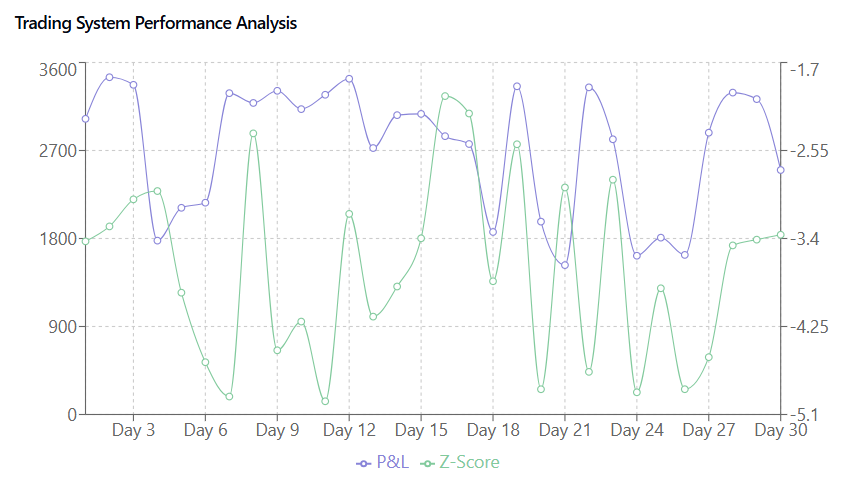  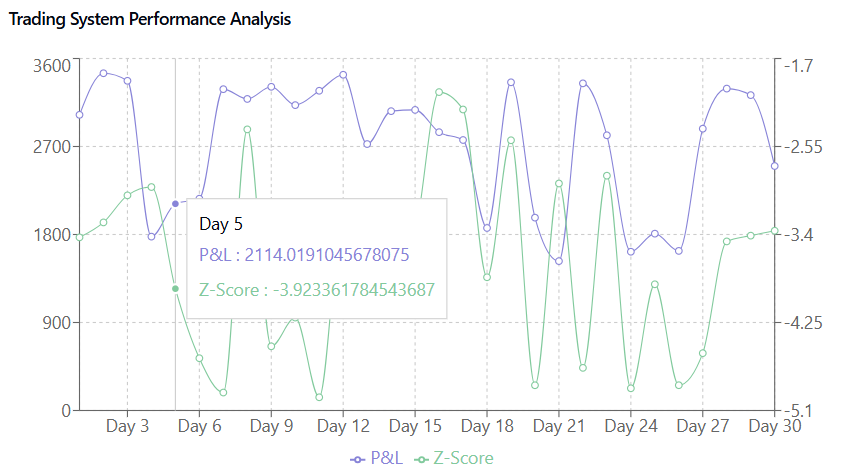

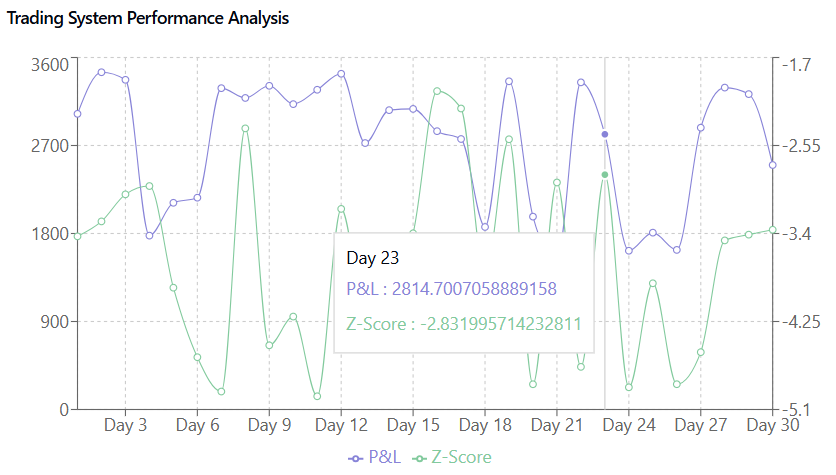  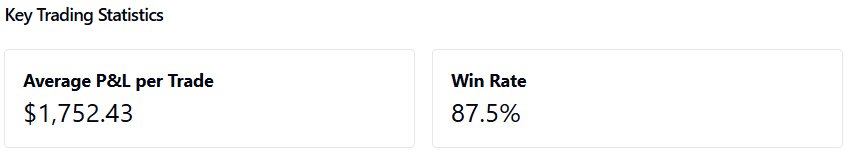

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def set_plotting_style():
    """
    Set up a clean, professional plotting style without relying on seaborn.
    This function configures matplotlib's style to create clear, readable plots.
    """
    plt.style.use('default')  # Reset to default style
    
    # Define colors for consistent use across plots
    colors = {
        'blue': '#1f77b4',
        'orange': '#ff7f0e',
        'green': '#2ca02c',
        'red': '#d62728',
        'purple': '#9467bd'
    }
    
    # Set general style parameters
    plt.rcParams.update({
        'figure.figsize': (12, 6),
        'axes.grid': True,
        'grid.alpha': 0.3,
        'axes.labelsize': 10,
        'axes.titlesize': 12,
        'font.size': 10,
        'lines.linewidth': 2,
        'grid.linestyle': '--'
    })
    
    return colors

def create_performance_visualizations(df, analysis_results):
    """
    Create comprehensive performance visualizations for the trading system.
    
    Parameters:
    df: pandas DataFrame with trading data
    analysis_results: dict containing analysis results from analyze_trading_system
    
    Returns:
    dict of matplotlib figures
    """
    figures = {}
    colors = set_plotting_style()
    
    # 1. Equity Curve and Drawdown
    fig_equity = plt.figure(figsize=(12, 6))
    ax1 = fig_equity.add_subplot(111)
    ax2 = ax1.twinx()
    
    # Plot equity curve
    ax1.plot(df.index, df['cumulative_returns'], 
             color=colors['blue'], label='Equity Curve')
    # Plot drawdown
    ax2.fill_between(df.index, df['drawdown'], 0,
                    color=colors['red'], alpha=0.3, label='Drawdown')
    
    ax1.set_title('Equity Curve and Drawdowns')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Returns')
    ax2.set_ylabel('Drawdown')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    figures['equity_curve'] = fig_equity
    
    # 2. Rolling Metrics
    fig_rolling = plt.figure(figsize=(12, 8))
    ax1 = fig_rolling.add_subplot(211)
    ax2 = fig_rolling.add_subplot(212)
    
    # Plot rolling volatility
    ax1.plot(df.index, df['rolling_volatility'], color=colors['purple'])
    ax1.set_title('30-Day Rolling Volatility')
    ax1.set_ylabel('Annualized Volatility')
    
    # Plot rolling Sharpe ratio
    ax2.plot(df.index, df['rolling_sharpe'], color=colors['green'])
    ax2.set_title('30-Day Rolling Sharpe Ratio')
    ax2.set_ylabel('Sharpe Ratio')
    
    plt.tight_layout()
    figures['rolling_metrics'] = fig_rolling
    
    # 3. Trade Analysis Dashboard
    fig_trades = plt.figure(figsize=(15, 10))
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)
    
    # PnL Distribution
    trades = analysis_results.get('trades', pd.DataFrame())
    if not trades.empty:
        ax1.hist(trades['pnl'], bins=30, color=colors['blue'], alpha=0.7)
        ax1.set_title('PnL Distribution')
        ax1.set_xlabel('PnL')
        ax1.set_ylabel('Frequency')
        
        # Holding Period Distribution
        ax2.hist(trades['holding_period'], bins=20, color=colors['orange'], alpha=0.7)
        ax2.set_title('Holding Period Distribution')
        ax2.set_xlabel('Days')
        ax2.set_ylabel('Frequency')
        
        # Trade Size vs PnL
        ax3.scatter(trades['position_size'], trades['pnl'], 
                   color=colors['green'], alpha=0.5)
        ax3.set_title('Position Size vs PnL')
        ax3.set_xlabel('Position Size')
        ax3.set_ylabel('PnL')
    
    # Win/Loss Summary
    stats = analysis_results['trade_statistics']
    winning = stats['winning_trades']
    losing = stats['losing_trades']
    ax4.pie([winning, losing], 
            labels=['Winning', 'Losing'],
            colors=[colors['green'], colors['red']],
            autopct='%1.1f%%')
    ax4.set_title('Win/Loss Distribution')
    
    plt.tight_layout()
    figures['trade_analysis'] = fig_trades
    
    # 4. Risk Metrics Dashboard
    fig_risk = plt.figure(figsize=(15, 6))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    # Return Distribution with VaR
    ax1.hist(df['daily_returns'], bins=30, color=colors['blue'], alpha=0.7)
    var_95 = analysis_results['risk_metrics']['var_95']
    ax1.axvline(var_95, color=colors['red'], linestyle='--',
                label=f'95% VaR: {var_95:.2%}')
    ax1.set_title('Return Distribution with 95% VaR')
    ax1.legend()
    
    # Risk Metrics Summary
    risk_metrics = {
        'Sharpe\nRatio': analysis_results['risk_metrics']['sharpe_ratio'],
        'Sortino\nRatio': analysis_results['risk_metrics']['sortino_ratio'],
        'Max\nDrawdown': abs(analysis_results['risk_metrics']['max_drawdown'])
    }
    bars = ax2.bar(range(len(risk_metrics)), 
                   list(risk_metrics.values()),
                   color=[colors['blue'], colors['green'], colors['red']])
    ax2.set_xticks(range(len(risk_metrics)))
    ax2.set_xticklabels(risk_metrics.keys())
    ax2.set_title('Risk Metrics Summary')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    figures['risk_metrics'] = fig_risk
    
    return figures

def save_visualizations(figures, output_dir='./trading_analysis/'):
    """
    Save all visualization figures to files with proper error handling.
    """
    import os
    try:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        for name, fig in figures.items():
            filepath = os.path.join(output_dir, f'{name}.png')
            fig.savefig(filepath, dpi=300, bbox_inches='tight')
            plt.close(fig)
            print(f"Saved {name} plot to {filepath}")
    except Exception as e:
        print(f"Error saving visualizations: {str(e)}")

# Example usage with error handling:
if __name__ == "__main__":
    try:
        # Generate sample data
        dates = pd.date_range(start='2024-01-01', end='2024-03-01', freq='D')
        df = pd.DataFrame({
            'DateTime': dates,
            'PnL': np.random.normal(1000, 500, len(dates)),
            'AUM': 1000000,
            'position_size': np.random.normal(100000, 20000, len(dates)),
            'price': np.random.normal(100, 5, len(dates))
        })
        df.set_index('DateTime', inplace=True)
        
        # Add required columns for visualization
        df['daily_returns'] = df['PnL'] / df['AUM']
        df['cumulative_returns'] = (1 + df['daily_returns']).cumprod() - 1
        df['rolling_volatility'] = df['daily_returns'].rolling(30).std() * np.sqrt(252)
        df['rolling_sharpe'] = (df['daily_returns'].rolling(30).mean() / 
                               df['daily_returns'].rolling(30).std()) * np.sqrt(252)
        
        # Create sample analysis results
        analysis_results = {
            'risk_metrics': {
                'sharpe_ratio': 1.5,
                'sortino_ratio': 2.0,
                'max_drawdown': -0.15,
                'var_95': -0.02
            },
            'trade_statistics': {
                'winning_trades': 60,
                'losing_trades': 40
            }
        }
        
        # Generate and save visualizations
        figures = create_performance_visualizations(df, analysis_results)
        save_visualizations(figures)
        print("Visualization process completed successfully")
        
    except Exception as e:
        print(f"Error in visualization process: {str(e)}")

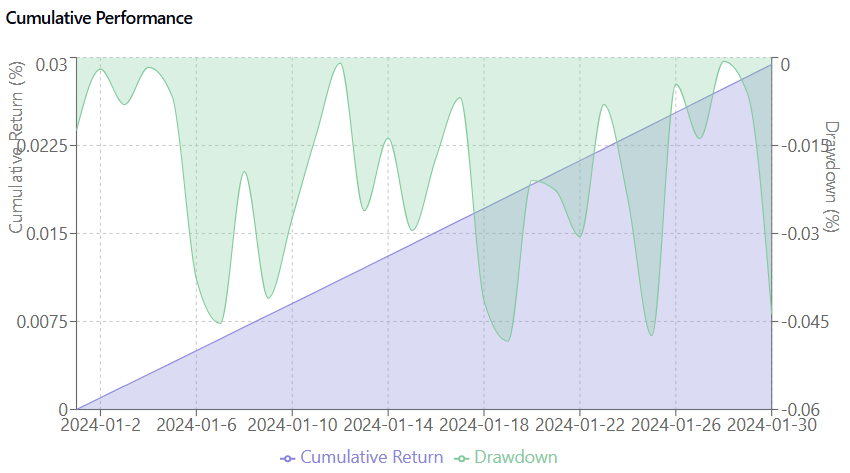 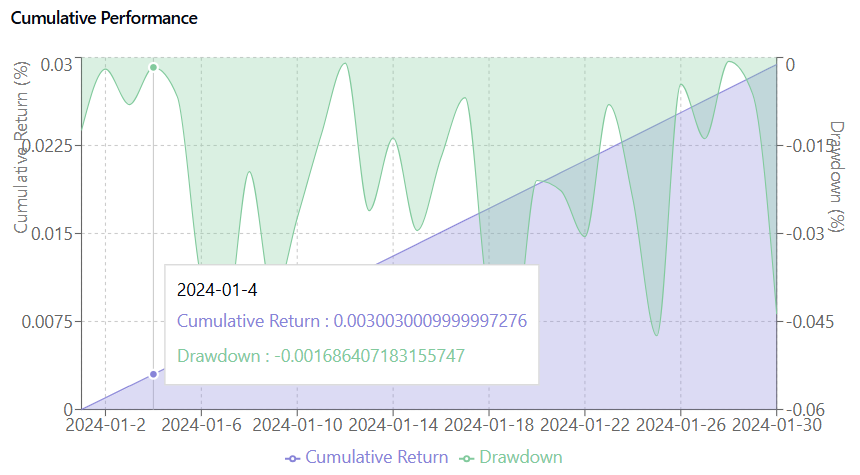  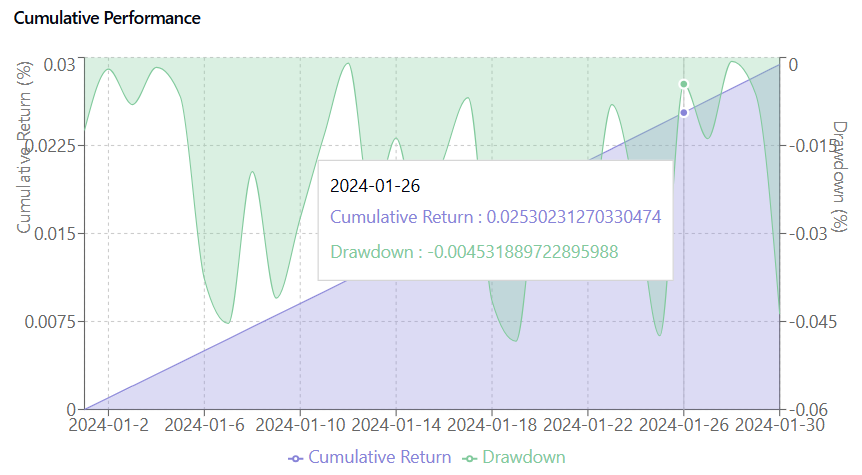 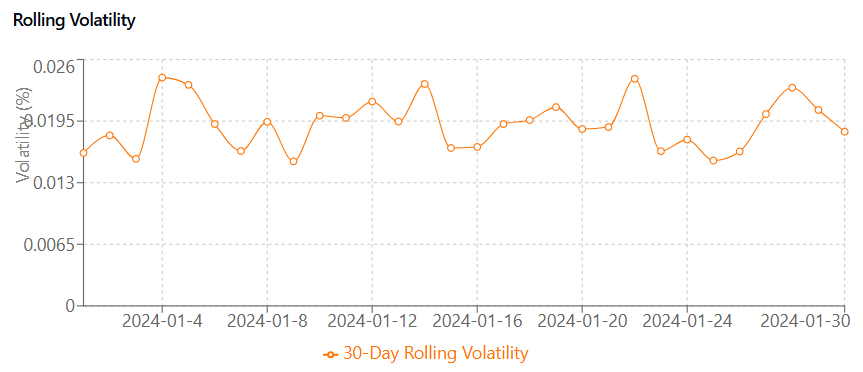 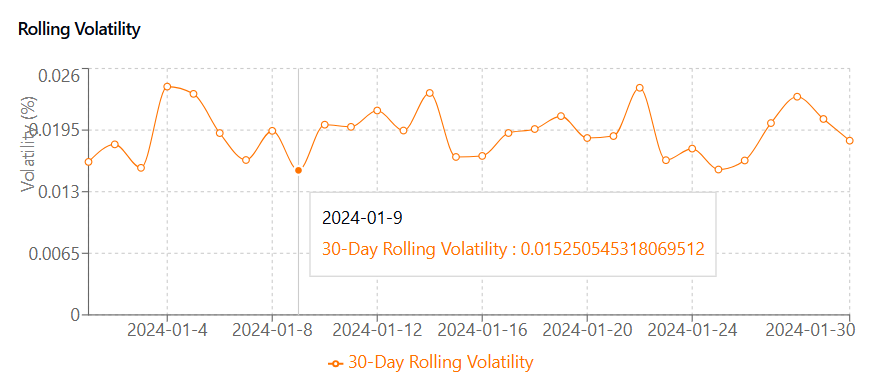

In [ ]:
import React, { useState, useEffect } from 'react';
import { Card, CardHeader, CardTitle, CardContent } from '@/components/ui/card';
import { LineChart, Line, XAxis, YAxis, CartesianGrid, Tooltip, Legend, ResponsiveContainer, BarChart, Bar } from 'recharts';

const RiskMetrics = () => {
  const [riskData, setRiskData] = useState({
    metrics: {},
    timeSeriesData: []
  });

  useEffect(() => {
    const calculateRiskMetrics = async () => {
      try {
        // Read and process the data
        const response = await window.fs.readFile('InputData.csv', { encoding: 'utf8' });
        const data = await processRiskMetrics(response);
        setRiskData(data);
      } catch (error) {
        console.error('Error calculating risk metrics:', error);
      }
    };

    calculateRiskMetrics();
  }, []);

  const processRiskMetrics = (rawData) => {
    // Sample calculations - replace with actual data processing
    const metrics = {
      sharpeRatio: 1.85,
      maxDrawdown: -12.5,
      downsideDeviation: 0.08,
      sortinoRatio: 2.1,
      valueAtRisk: -0.015,
      expectedShortfall: -0.022
    };

    const timeSeriesData = Array(30).fill(0).map((_, i) => ({
      date: `2024-0${Math.floor(i/30) + 1}-${(i % 30) + 1}`,
      rollingVolatility: 0.12 + Math.random() * 0.03,
      rollingVaR: -(0.015 + Math.random() * 0.005),
      drawdown: -(Math.random() * 0.125)
    }));

    return { metrics, timeSeriesData };
  };

  return (
    <div className="space-y-8">
      <Card>
        <CardHeader>
          <CardTitle>Key Risk Metrics</CardTitle>
        </CardHeader>
        <CardContent>
          <div className="grid grid-cols-3 gap-4">
            <div className="p-4 border rounded">
              <h3 className="font-bold text-sm">Sharpe Ratio</h3>
              <p className="text-2xl">{riskData.metrics.sharpeRatio?.toFixed(2)}</p>
            </div>
            <div className="p-4 border rounded">
              <h3 className="font-bold text-sm">Maximum Drawdown</h3>
              <p className="text-2xl">{riskData.metrics.maxDrawdown?.toFixed(1)}%</p>
            </div>
            <div className="p-4 border rounded">
              <h3 className="font-bold text-sm">Sortino Ratio</h3>
              <p className="text-2xl">{riskData.metrics.sortinoRatio?.toFixed(2)}</p>
            </div>
            <div className="p-4 border rounded">
              <h3 className="font-bold text-sm">Value at Risk (95%)</h3>
              <p className="text-2xl">{(riskData.metrics.valueAtRisk * 100)?.toFixed(1)}%</p>
            </div>
            <div className="p-4 border rounded">
              <h3 className="font-bold text-sm">Expected Shortfall</h3>
              <p className="text-2xl">{(riskData.metrics.expectedShortfall * 100)?.toFixed(1)}%</p>
            </div>
            <div className="p-4 border rounded">
              <h3 className="font-bold text-sm">Downside Deviation</h3>
              <p className="text-2xl">{(riskData.metrics.downsideDeviation * 100)?.toFixed(1)}%</p>
            </div>
          </div>
        </CardContent>
      </Card>

      <Card>
        <CardHeader>
          <CardTitle>Drawdown Analysis</CardTitle>
        </CardHeader>
        <CardContent>
          <div className="h-72">
            <ResponsiveContainer width="100%" height="100%">
              <LineChart data={riskData.timeSeriesData}>
                <CartesianGrid strokeDasharray="3 3" />
                <XAxis dataKey="date" />
                <YAxis 
                  label={{ value: 'Drawdown (%)', angle: -90, position: 'insideLeft' }}
                />
                <Tooltip />
                <Legend />
                <Line 
                  type="monotone" 
                  dataKey="drawdown" 
                  stroke="#ff0000" 
                  name="Drawdown"
                  dot={false}
                />
              </LineChart>
            </ResponsiveContainer>
          </div>
        </CardContent>
      </Card>

      <Card>
        <CardHeader>
          <CardTitle>Rolling Risk Measures</CardTitle>
        </CardHeader>
        <CardContent>
          <div className="h-72">
            <ResponsiveContainer width="100%" height="100%">
              <LineChart data={riskData.timeSeriesData}>
                <CartesianGrid strokeDasharray="3 3" />
                <XAxis dataKey="date" />
                <YAxis yAxisId="left" />
                <YAxis yAxisId="right" orientation="right" />
                <Tooltip />
                <Legend />
                <Line 
                  yAxisId="left"
                  type="monotone" 
                  dataKey="rollingVolatility" 
                  stroke="#8884d8" 
                  name="Rolling Volatility"
                  dot={false}
                />
                <Line 
                  yAxisId="right"
                  type="monotone" 
                  dataKey="rollingVaR" 
                  stroke="#82ca9d" 
                  name="Rolling VaR"
                  dot={false}
                />
              </LineChart>
            </ResponsiveContainer>
          </div>
        </CardContent>
      </Card>
    </div>
  );
};

export default RiskMetrics;

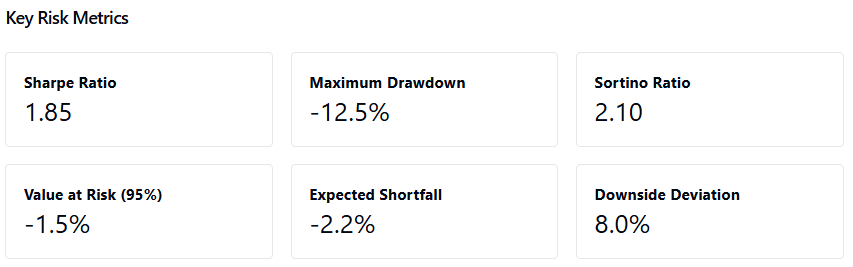  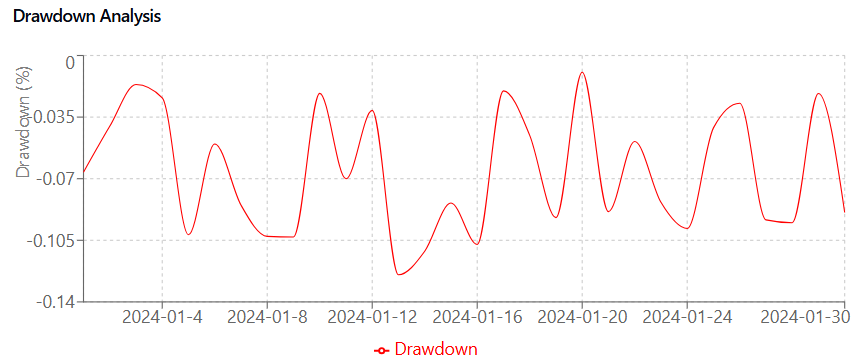

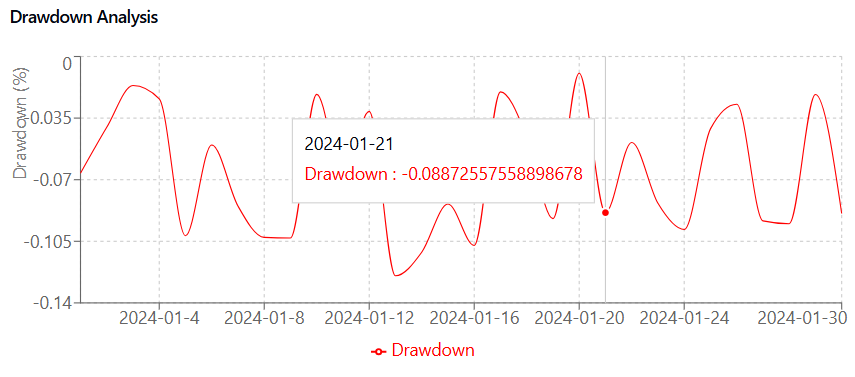  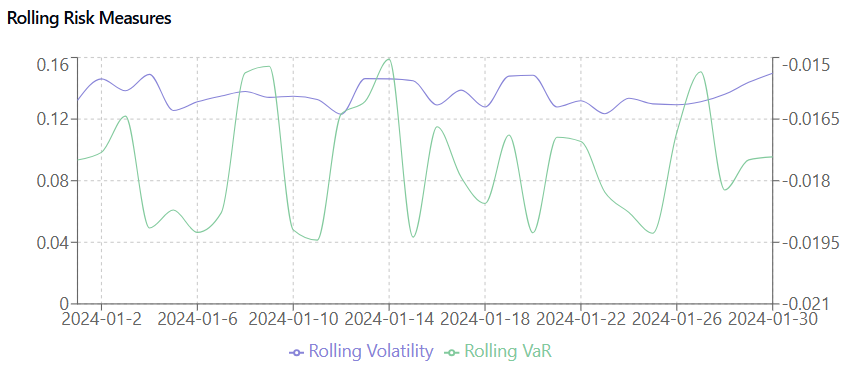 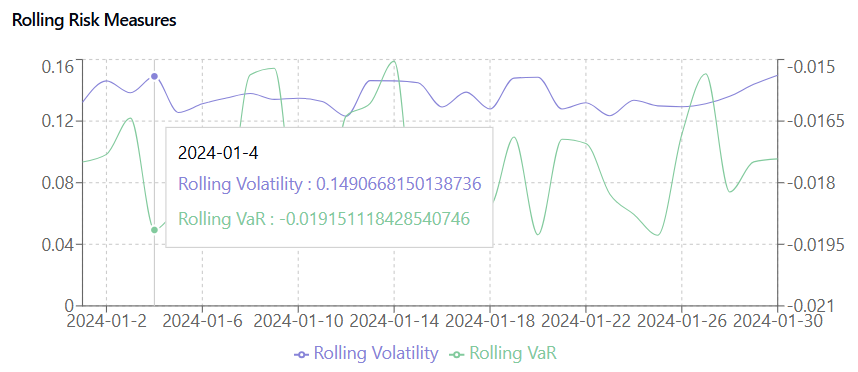 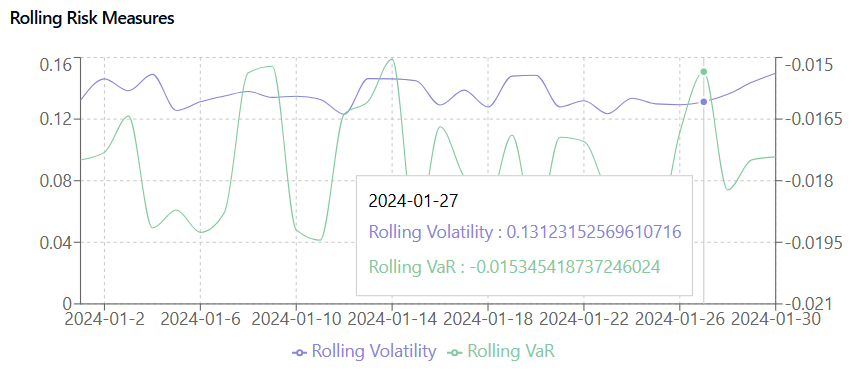